# Intro to RAPIDS using the New York City Yellow Taxi Data 
light on Data Science, heavy on comparisons.

This notebook is for the The Toronto Machine Learning Summit, Nov 16 -29, 2020

![TMLS](./img/TMLS.png)

This notebook includes

* cudf - for basic ETL and some __statistical analysis__ 
* cuml - for __machine learning__
* cugraph - for some __graph analysis__
* cuxfilter - for __visualization__


----
# Setup

In [33]:
# load the libraries
import cudf

import numpy as np
import pandas as pd
import math

import os
import gc

from collections import OrderedDict
import argparse
import datetime
import time

In [34]:
try: 
    import tqdm
except ModuleNotFoundError:
    os.system('pip install tqdm')
    import tqdm

In [35]:
# Let's use Unified Memory (aka managed memory) so that we try and avoid OOM errors 
# start by importing the RAPIDS Memory Manager and then reinitializing with managed memory turn on
import rmm

rmm.reinitialize(   
    managed_memory=True,        # Use managed memory, this allows for oversubscription of the GPU
    pool_allocator=False,       # default is False
    devices=0,                  # GPU device IDs to register. By default, registers only GPU 0.
)

## Download the data

----

# cuDF - Accelerated Data Frame 

In [48]:
# get a list of files
data_path = top_dir + "nyctaxi/2016"

files = []

for f in sorted(os.listdir(data_path)):
    if f[0:6] != 'yellow':
        continue
        
    fname = os.path.join(data_path, f)
            
    files.append(fname)


In [52]:
files

['./nyctaxi/2016/yellow_tripdata_2016-01.csv',
 './nyctaxi/2016/yellow_tripdata_2016-02.csv']

In [53]:
!du -sh $data_path

3.3G	./nyctaxi/2016


## Loading data performance test

In [54]:
def read_pandas(f):
    start_t = time.time()
    df = pd.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [55]:
def read_cudf(f):
    start_t = time.time()
    df = cudf.read_csv(f)
    end_t = time.time() - start_t

    return df, end_t

In [56]:
# Load data with Pandas

data = []

start_t = time.time()

for f in files:
    print("\treading " + f, end = '')
    df, t = read_pandas(f)
    print(" ... in time of " + str(t) + " seconds")
    data.append(df)
  
taxi_pdf = pd.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_pdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 14.29497480392456 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv ... in time of 14.645810604095459 seconds
loaded 22,288,907 records in 30.577734  seconds


In [57]:
# Load data with RAPIDS cuDF

data = []

start_t = time.time()

for f in files:
    print("\treading " + f, end = '')
    df, t = read_cudf(f)
    print(" ... in time of " + str(t)+ " seconds")
    data.append(df)

taxi_gdf = cudf.concat(data)

end_t = time.time()

print(f"loaded {len(taxi_gdf):,} records in {(end_t - start_t):2f}  seconds")

del data

	reading ./nyctaxi/2016/yellow_tripdata_2016-01.csv ... in time of 0.8168251514434814 seconds
	reading ./nyctaxi/2016/yellow_tripdata_2016-02.csv ... in time of 0.8759584426879883 seconds
loaded 22,288,907 records in 2.039180  seconds


In [58]:
taxi_gdf.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


## Sort Comparisons - Single Field

In [59]:
%%time
sp = taxi_pdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 13.8 s, sys: 288 ms, total: 14.1 s
Wall time: 14.1 s


In [60]:
%%time
sg = taxi_gdf.sort_values(by='trip_distance',ascending=False)

CPU times: user 350 ms, sys: 192 ms, total: 542 ms
Wall time: 542 ms


## Group By - Single Column 

In [61]:
%%time
gbp = taxi_pdf.groupby('passenger_count').count()

CPU times: user 7.19 s, sys: 0 ns, total: 7.19 s
Wall time: 7.18 s


In [62]:
%%time
gbg = taxi_gdf.groupby('passenger_count').count()

CPU times: user 163 ms, sys: 51.8 ms, total: 215 ms
Wall time: 213 ms


## Fun with Data

In [63]:
%%time
print(f"Max fare was ${taxi_pdf['fare_amount'].max():,}")

Max fare was $154,810.43
CPU times: user 33.9 ms, sys: 244 µs, total: 34.2 ms
Wall time: 32.2 ms


In [64]:
%%time
print(f"Max fare was ${taxi_gdf['fare_amount'].max():,}")

Max fare was $154,810.43
CPU times: user 4.69 ms, sys: 2.94 ms, total: 7.63 ms
Wall time: 6.2 ms


In [65]:
# looking at that huge fare
maxf = taxi_gdf['fare_amount'].max()
taxi_gdf.query('fare_amount == @maxf')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
7840169,1,2016-02-23 14:26:33,2016-02-23 15:03:09,1,298914.2,-73.782318,40.644581,2,N,-73.988487,40.737961,3,154810.43,20.55,1.16,0.0,0.0,0.0,154832.14


In [66]:
print(f"Farthest trip was {taxi_gdf['trip_distance'].max():,} miles")

Farthest trip was 11,658,534.3 miles


In [67]:
# How long did it take to drive that distance?
maxd= taxi_gdf['trip_distance'].max()
taxi_gdf.query('trip_distance == @maxd')

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
3963837,1,2016-02-13 09:20:43,2016-02-13 09:22:00,3,11658534.3,-73.945442,40.751583,1,N,-73.945442,40.751583,2,2.5,0.0,0.5,0.0,0.0,0.3,3.3


### Changing data types

In [68]:
# change some data types
taxi_gdf = taxi_gdf.astype({'tpep_pickup_datetime':'datetime64[ms]', 'tpep_dropoff_datetime':'datetime64[ms]'})

### Filtering data

In [69]:
# filter out records with missing or outlier values
query_frags = ("(fare_amount > 0 and fare_amount < 500) " +
        "and (passenger_count > 0 and passenger_count < 6) " +
        "and (pickup_longitude > -75 and pickup_longitude < -73) " +
        "and (dropoff_longitude > -75 and dropoff_longitude < -73) " +
        "and (pickup_latitude > 40 and pickup_latitude < 42) " +
        "and (dropoff_latitude > 40 and dropoff_latitude < 42)" +
        "and (pickup_latitude != dropoff_latitude) " +
        "and (pickup_longitude != dropoff_longitude)"
    )

taxi_gdf = taxi_gdf.query(query_frags)

### Add some new features

In [70]:
# easier to reference time by YYYY MM DD version a time stamps
taxi_gdf['hour']  = taxi_gdf['tpep_pickup_datetime'].dt.hour
taxi_gdf['year']  = taxi_gdf['tpep_pickup_datetime'].dt.year
taxi_gdf['month'] = taxi_gdf['tpep_pickup_datetime'].dt.month
taxi_gdf['day']   = taxi_gdf['tpep_pickup_datetime'].dt.day
taxi_gdf['diff']  = taxi_gdf['tpep_dropoff_datetime'].astype('int64') - taxi_gdf['tpep_pickup_datetime'].astype('int64')

In [71]:
def day_of_the_week_kernel(day, month, year, day_of_week):
    for i, (d_1, m_1, y_1) in enumerate(zip(day, month, year)):
        if month[i] < 3:
            shift = month[i]
        else:
            shift = 0
        Y = year[i] - (month[i] < 3)
        y = Y - 2000
        c = 20
        d = day[i]
        m = month[i] + shift + 1
        day_of_week[i] = (d + math.floor(m * 2.6) + y + (y // 4) + (c // 4) - 2 * c) % 7
        
taxi_gdf = taxi_gdf.apply_rows(
        day_of_the_week_kernel
        , incols = ['day', 'month', 'year']
        , outcols = {'day_of_week': np.int32}
        , kwargs = {}
    )

In [72]:
taxi_gdf.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,hour,year,month,day,diff,day_of_week
0,2,2016-01-01,2016-01-01,2,1.10,-73.990372,40.734695,1,N,-73.981842,...,0.0,0.0,0.3,8.8,0,2016,1,1,0,5
1,2,2016-01-01,2016-01-01,5,4.90,-73.980782,40.729912,1,N,-73.944473,...,0.0,0.0,0.3,19.3,0,2016,1,1,0,5
2,2,2016-01-01,2016-01-01,1,10.54,-73.984550,40.679565,1,N,-73.950272,...,0.0,0.0,0.3,34.3,0,2016,1,1,0,5
3,2,2016-01-01,2016-01-01,1,4.75,-73.993469,40.718990,1,N,-73.962242,...,0.0,0.0,0.3,17.3,0,2016,1,1,0,5
4,2,2016-01-01,2016-01-01,3,1.76,-73.960625,40.781330,1,N,-73.977264,...,0.0,0.0,0.3,8.8,0,2016,1,1,0,5


---

## Basic Statistical Data Science

### Look at some feature - by Hour

<AxesSubplot:xlabel='hour'>

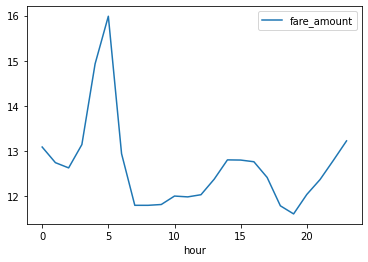

In [73]:
# 1) Let's look at a plot of fare by hour
%matplotlib inline
taxi_gdf.groupby('hour').fare_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='hour'>

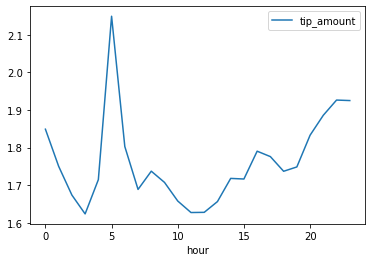

In [74]:
# 2) Tips by hour
%matplotlib inline
taxi_gdf.groupby('hour').tip_amount.mean().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

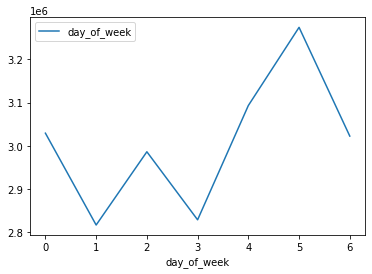

In [76]:
# Look at what days are the busiest
%matplotlib inline
taxi_gdf.groupby('day_of_week').day_of_week.count().to_pandas().sort_index().plot(legend=True)

<AxesSubplot:xlabel='day_of_week'>

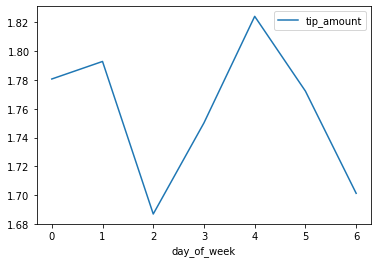

In [77]:
# What days have the best tips
%matplotlib inline
taxi_gdf.groupby('day_of_week').tip_amount.mean().to_pandas().sort_index().plot(legend=True)